In [1]:
!git clone https://github.com/TruptiRadadiya/Emotion_Classifier.git

Cloning into 'Emotion_Classifier'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 348 (delta 7), reused 38 (delta 1), pack-reused 294 (from 1)
Receiving objects: 100% (348/348), 48.45 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import tensorflow as tf                                                                          # tensorflow module for training model

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "/content/Emotion_Classifier/Resources"                                    # Path of data
image_exts = ['jpeg' , 'jpg' ,'bmp' , 'png']                # possible image extensions
categories = ["Happy","Sad"]                                # Storing all the categories in categories variable

In [4]:
# Creating 4 different lists to store the image names for each category by reading them from their respective directories.
happy_imgs = [img for img in os.listdir(f'{data_dir}/{categories[0]}') ]          # Looping over the path of each image from the happy directory
sad_imgs = [img for img in os.listdir(f'{data_dir}/{categories[1]}')]            # Looping over the path of each image from the sad directory

# Ranodmly selecting 5 images from each category
select_happy = np.random.choice(happy_imgs, 5, replace = False)
select_sad = np.random.choice(sad_imgs, 5, replace = False)

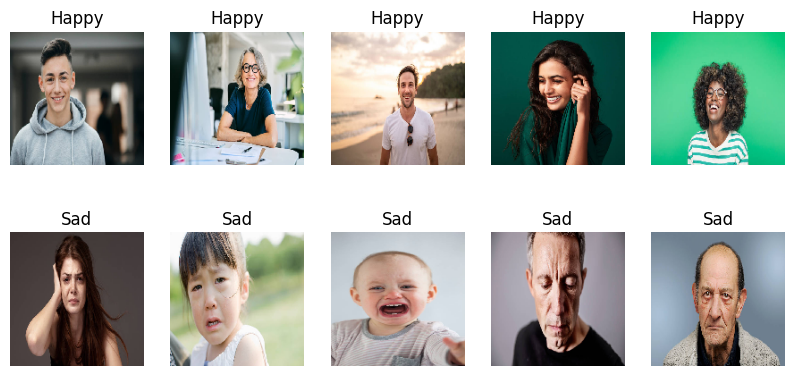

In [5]:
# plotting 4 x 5 image matrix
fig = plt.figure(figsize = (10,10))

# Plotting five images from each of the four categories by looping through their path
for i in range(10):
    if i < 5:
        fp = f'{data_dir}/{categories[0]}/{select_happy[i]}'                    # Here datadir is a path to the training data and categories[0] indicate the first label bread and here we are looping over to take the three random images that we have stored in select_galo variable
        label = 'Happy'
    if i>=5 and i<10:
        fp = f'{data_dir}/{categories[1]}/{select_sad[i-5]}'                   # Here datadir is a path to the training data and categories[1] indicate the second label soup and here we are looping over to take the three random images that we have stored in select_menin variable
        label = 'Sad'
    ax = fig.add_subplot(4, 5, i+1)

    # Plotting each image using load_img function
    fn = tf.keras.preprocessing.image.load_img(fp,target_size = (150,150))
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [6]:
# Here we will be using a user defined function create_training_data() to extract the images from the directory
img_size = 150
data = []                                                             # Storing all the training images
def create_data():
    for category in categories:                                                # Looping over each category from the categories list
        path = os.path.join(data_dir,category)                                  # Joining images with labels
        class_num = category
        for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path,img))                       # Reading the data
          new_array = cv2.resize(img_array,(img_size,img_size))                # Resizing the images
          data.append([new_array,class_num])                          # Appending both the images and labels
create_data()

In [7]:
# Creating two different lists to store the Numpy arrays and the corresponding labels
images = []
labels = []
np.random.shuffle(data)                                               # Shuffling data to reduce variance and making sure that model remains general and overfit less
for features,label in data:                                           # Iterating over the training data which is generated from the create_training_data() function
    images.append(features)                                                   # Appending images into X_train
    labels.append(label)

In [8]:
# Converting the list into DataFrame
labels = pd.DataFrame(labels, columns=["Label"],dtype=object)

In [9]:
# Storing the value counts of target variable
count=labels.Label.value_counts()
print(count)
print('*'*10)
count=labels.Label.value_counts(normalize=True)
print(count)

Label
Happy    166
Sad      100
Name: count, dtype: int64
**********
Label
Happy    0.62406
Sad      0.37594
Name: proportion, dtype: float64


In [10]:
# Converting the pixel values into Numpy array
images= np.array(images)

In [11]:
images.shape

(266, 150, 150, 3)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images),labels,random_state=42,stratify=labels)

In [13]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(199, 150, 150, 3) (199, 1)
(67, 150, 150, 3) (67, 1)


In [14]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [15]:
print(X_train_normalized.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(199, 150, 150, 3) (199, 1)
(67, 150, 150, 3) (67, 1)


In [16]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded=enc.transform(y_test)

In [17]:
print(X_train.shape,y_train_encoded.shape)

(199, 150, 150, 3) (199, 1)


In [18]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [19]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(hp.Int('conv_1_units', min_value=16, max_value=64, step=16),
                                     kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(hp.Int('conv_2_units', min_value=16, max_value=64, step=16),
                                     kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10)
tuner.search(X_train_normalized, y_train_encoded, epochs=20, validation_data=(X_test_normalized, y_test_encoded))
best_model = tuner.get_best_models()[0]


Trial 10 Complete [00h 03m 31s]
val_accuracy: 0.7910447716712952

Best val_accuracy So Far: 0.7910447716712952
Total elapsed time: 00h 56m 40s


In [20]:
# Print the best hyperparameters and accuracy
print(best_model.get_config())
print("Best accuracy:", best_model.evaluate(X_test_normalized, y_test_encoded)[1])

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 150, 150, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_na

In [21]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'conv_1_units': 16,
 'conv_2_units': 48,
 'dense_units': 384,
 'learning_rate': 0.001}

In [22]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 1s - 386ms/step - accuracy: 0.7910 - loss: 0.5092
Loss: 0.5092484354972839, Accuracy: 0.7910447716712952


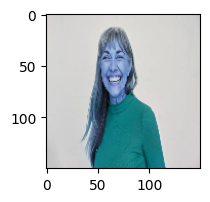

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Label ['Happy']
True Label Happy


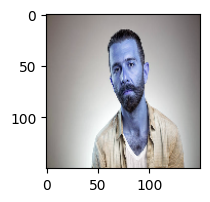

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label ['Happy']
True Label Sad


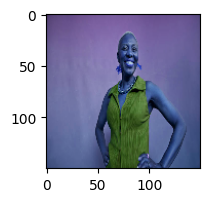

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Label ['Happy']
True Label Happy


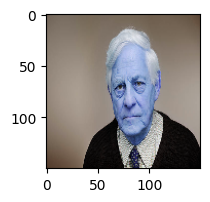

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label ['Happy']
True Label Sad


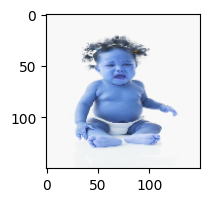

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Label ['Happy']
True Label Sad


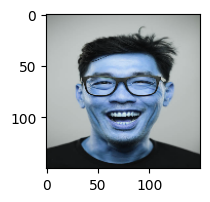

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Label ['Happy']
True Label Happy


In [24]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[0])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[0].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[0])                                               # using inverse_transform() to get the output label from the output vector

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[22])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[22].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[22])                                               # using inverse_transform() to get the output label from the output vector

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[11])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[11].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[11])

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[45])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[45].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[45])

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[35])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[35].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[35])

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[50])
plt.show()
print('Predicted Label', enc.inverse_transform(best_model.predict((X_test_normalized[50].reshape(1,150,150,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[50])

In [25]:
# Export our model to HDF5 file
best_model.save("Models/EmotionClassifierOptimize4.h5")